# Modeling Notebook

For this project, we will be focusing on producing a model with the greatest predictive power. We will not be worrying as much about interpretability of the results, as our feature space is already non-interpretable. 

We will be using a variety of models, including a Logistic Regression, K-Nearest Neighbors, Gradient Boosting, a Fully Connected Neural Network, and a Bidirectional LSTM.

To evaluate each model, we'll calculate the Accuracy and F1 scores as our main metrics: Accuracy because it is the most straightforward, and F1-Score as it strikes a good balance between precision and recall. We will also be using the ROC AUC score as a metric because it demonstrates the model's ability to distinguish between classes. All metrics will be computed under 5-fold cross-validation to prevent overfitting and increase inferential power.

## Imports & Load Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.model_selection import (train_test_split, RandomizedSearchCV,
                                     cross_val_score, GridSearchCV)
from sklearn.metrics import (accuracy_score, confusion_matrix, classification_report,
                            ConfusionMatrixDisplay, roc_auc_score, roc_curve, f1_score)
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('../data/embeddings_with_status.csv', index_col=0)
X = df.drop(['status'], axis=1)
y = df['status']

#### Train/Test Split

In [3]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=42)
print(Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape)
Xtrain.head()

(3444, 384) (862, 384) (3444,) (862,)


,0,1,2,3,4,5,6,7,8,9,...,374,375,376,377,378,379,380,381,382,383
1611,0.009626,-0.012624,-0.031996,-0.020114,-0.100397,0.072743,0.036871,0.033415,-0.008293,0.076819,...,-0.015646,0.061471,0.027147,0.053586,-0.025169,-0.060692,0.146723,-0.040872,-0.014797,-0.054450
1566,0.035310,0.085344,-0.028020,0.000276,-0.022207,0.049991,0.031906,0.073466,0.028291,0.011634,...,0.009232,-0.029688,-0.015444,0.070441,-0.027810,-0.024100,0.021448,-0.025837,0.049525,-0.051304
1323,-0.059797,-0.023852,-0.019669,0.008600,-0.066486,-0.015696,0.070561,-0.026989,-0.048446,0.023195,...,-0.033379,-0.007500,0.046573,0.072056,-0.034374,-0.070055,0.078877,-0.082879,0.000558,-0.041836
1610,-0.036708,0.027534,-0.035764,-0.050514,-0.048086,0.026700,0.083809,0.030049,-0.014567,0.032028,...,-0.012458,0.033953,0.011051,0.016477,-0.003810,0.014991,0.054450,0.011111,-0.074233,0.000618
3270,-0.080542,0.014521,0.026716,0.010496,-0.023631,0.050562,0.102809,0.029783,-0.027436,0.020591,...,0.026506,-0.069198,-0.061411,0.061796,-0.060329,-0.036146,0.033546,0.022928,0.019619,-0.036110


In [4]:
ytrain.head()

1611    0
1566    2
1323    2
1610    1
3270    0
Name: status, dtype: int64

## Baseline Model

We will run a `DummyClassifier` with the `most_frequent` strategy to determine our baseline model's metrics.

In [5]:
# taking a quick look at the distribution of the target variable
ytrain.value_counts(normalize=True)

0    0.391405
1    0.364692
2    0.243902
Name: status, dtype: float64

In [6]:
dummy = DummyClassifier(
    strategy='most_frequent',
    random_state=42)
dummy.fit(Xtrain, ytrain)
ypred = dummy.predict(Xtest)

In [7]:
print('Accuracy:', accuracy_score(ytest, ypred))
print('F1:', f1_score(ytest, ypred, average='weighted'))

Accuracy: 0.3723897911832947
F1: 0.20209150121696973


In [8]:
print(classification_report(ytest, ypred))

              precision    recall  f1-score   support

           0       0.37      1.00      0.54       321
           1       0.00      0.00      0.00       340
           2       0.00      0.00      0.00       201

    accuracy                           0.37       862
   macro avg       0.12      0.33      0.18       862
weighted avg       0.14      0.37      0.20       862



In [62]:
ytest_mat = pd.get_dummies(ytest)
ypred_mat = pd.get_dummies(ypred)
print(roc_auc_score(ytest_mat, ypred_mat, multi_class='ovo'))

0.5


> Predicting the `Not_Implemented` class each time will yield an accuracy of 37% and an F1 score of 0.20.

___

## Logistic Regression

We'll fit a simple logistic regression model to our data and evaluate its performance under 5-fold cross validation.

In [64]:
reg = LogisticRegression(max_iter=1000, random_state=42, multi_class='auto')
reg.fit(Xtrain, ytrain)
print("Training Score: ", cross_val_score(reg, Xtrain, ytrain, cv=5).mean())
print("Testing Score: ", cross_val_score(reg, Xtest, ytest, cv=5).mean())

Training Score:  0.46370793532926047
Testing Score:  0.44315768248420484


Heyo! We already see some improvement over our baseline model. Let's see if we can improve the performance of our model by tuning the hyperparameters.

> None of the grid searching below yielded any significant improvements in performance, so we will be using the default parameters for the logistic regression model.

In [65]:
# optimize hyperparameters
param_grid = {
    'C': np.logspace(2, 4, 10),
    'penalty': ['none','l2'],
}
gs = GridSearchCV(reg, param_grid, cv=5, verbose=1, n_jobs=-1)
# gs.fit(Xtrain, ytrain)
# print(gs.score(Xtrain, ytrain))
# print(gs.score(Xtest, ytest))

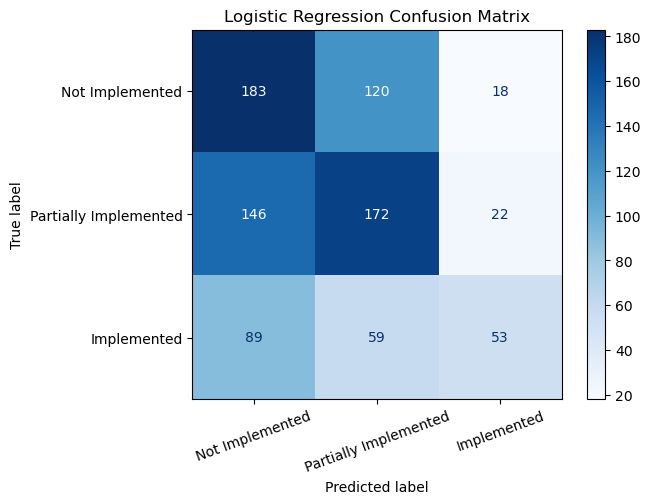

In [66]:
# confusion matrix
y_pred = reg.predict(Xtest)
cm = confusion_matrix(ytest, y_pred)
ConfusionMatrixDisplay(cm, display_labels=['Not Implemented', 'Partially Implemented', 'Implemented']).plot(
    values_format='d', cmap='Blues', xticks_rotation=20)
plt.title('Logistic Regression Confusion Matrix');

In [67]:
print(classification_report(ytest, y_pred))

              precision    recall  f1-score   support

           0       0.44      0.57      0.50       321
           1       0.49      0.51      0.50       340
           2       0.57      0.26      0.36       201

    accuracy                           0.47       862
   macro avg       0.50      0.45      0.45       862
weighted avg       0.49      0.47      0.46       862



#### ROC AUC Score

In [68]:
ytest_mat = pd.get_dummies(ytest)
ypred_mat = pd.get_dummies(ypred)
print(roc_auc_score(ytest_mat, ypred_mat, multi_class='ovo'))

0.5


___

## KNN Classifier

In [70]:
sc = StandardScaler()
Ztrain = sc.fit_transform(Xtrain)
Ztest = sc.transform(Xtest)

In [71]:
knn = KNeighborsClassifier(n_neighbors=17)
knn.fit(Ztrain, ytrain)
print(cross_val_score(knn, Ztrain, ytrain, cv=5).mean())
print(cross_val_score(knn, Ztest, ytest, cv=5).mean())

0.4427971107435785
0.4349912622664337


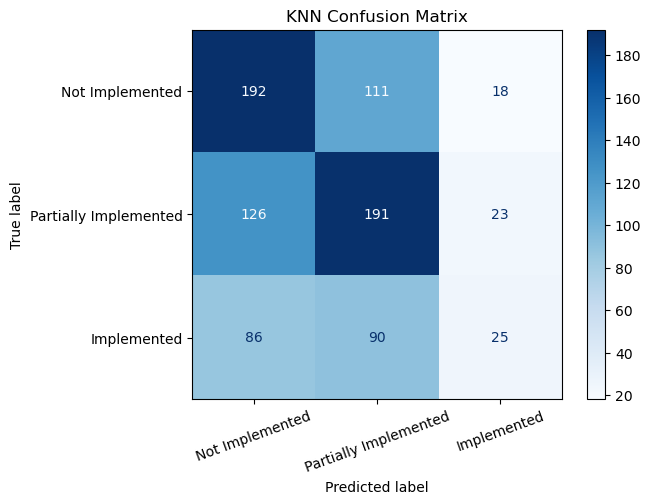

In [72]:
# confusion matrix
y_pred = knn.predict(Ztest)
cm = confusion_matrix(ytest, y_pred)
ConfusionMatrixDisplay(cm, display_labels=['Not Implemented', 'Partially Implemented', 'Implemented']).plot(
    values_format='d', cmap='Blues', xticks_rotation=20)
plt.title('KNN Confusion Matrix');

In [73]:
print(classification_report(ytest, y_pred))

              precision    recall  f1-score   support

           0       0.48      0.60      0.53       321
           1       0.49      0.56      0.52       340
           2       0.38      0.12      0.19       201

    accuracy                           0.47       862
   macro avg       0.45      0.43      0.41       862
weighted avg       0.46      0.47      0.45       862



#### ROC AUC Score

In [74]:
ytest_mat = pd.get_dummies(ytest)
ypred_mat = pd.get_dummies(ypred)
print(roc_auc_score(ytest_mat, ypred_mat, multi_class='ovo'))

0.5


___

## Gradient Boosting Classifier

Let's see the out of the box performance of a Gradient Boosting Classifier.

In [75]:
gb = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb.fit(Xtrain, ytrain)
print(cross_val_score(gb, Xtrain, ytrain, cv=5).mean())
print(cross_val_score(gb, Xtest, ytest, cv=5).mean())

0.46022293853579505
0.4408253797553434


#### Randomized Search

In [76]:
# param_grid = {
#     'n_estimators': np.arange(100, 1000, 100),
#     'max_depth': np.arange(1, 5, 1),
#     'min_samples_leaf': np.arange(1, 5, 1),
#     'random_state': [42]
# }
# rs = RandomizedSearchCV(gb, param_grid, cv=5, verbose=1, n_jobs=-1, n_iter=10)
# rs.fit(Xtrain, ytrain)
# print('Train score: ', rs.score(Xtrain, ytrain))
# print('Test score: ', rs.score(Xtest, ytest))

##### Pickle Model

In [77]:
# best = rs.best_estimator_
# import pickle
# # create a file to store the model
# pickle.dump(best, open('models/grad_boost.pkl', 'wb'))

#### Loading Pickled Model

In [78]:
gb = pickle.load(open('../models/grad_boost.pkl', 'rb'))

In [79]:
gb.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 4,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 800,
 'n_iter_no_change': None,
 'random_state': 42,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [80]:
# Show accuracy score --> it's already been cross validated in the RandomizedSearchCV
print('Train score: ', gb.score(Xtrain, ytrain))
print('Test score: ', gb.score(Xtest, ytest))

Train score:  1.0
Test score:  0.4918793503480278


> This model is tremendously overfit, but it is performing better than the simpler logistic regression and KNN models.

### Model Evaluation

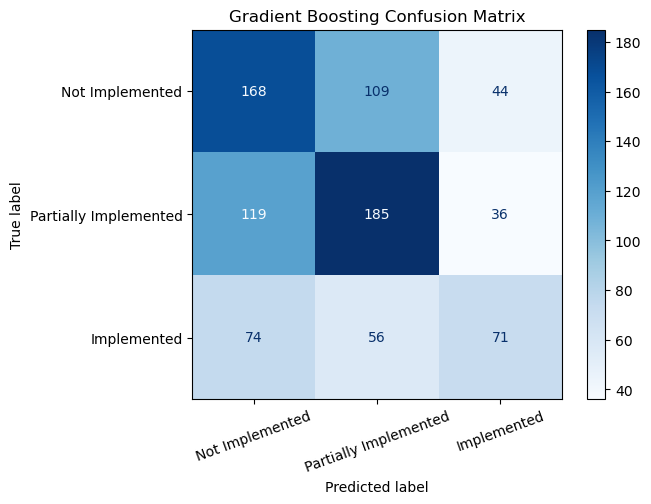

In [81]:
# Show confusion matrix
y_pred = gb.predict(Xtest)
cm = confusion_matrix(ytest, y_pred)
cm_display = (
    ConfusionMatrixDisplay(
        cm,
        display_labels=[
            'Not Implemented',
            'Partially Implemented',
            'Implemented']
        )
    .plot(
        values_format='d',
        cmap='Blues',
        xticks_rotation=20
        )
    )
plt.title('Gradient Boosting Confusion Matrix');

In [82]:
print(classification_report(ytest, y_pred))

              precision    recall  f1-score   support

           0       0.47      0.52      0.49       321
           1       0.53      0.54      0.54       340
           2       0.47      0.35      0.40       201

    accuracy                           0.49       862
   macro avg       0.49      0.47      0.48       862
weighted avg       0.49      0.49      0.49       862



In [83]:
ytest_mat = pd.get_dummies(ytest)
ypred_mat = pd.get_dummies(ypred)
print(roc_auc_score(ytest_mat, ypred_mat, multi_class='ovo'))

0.5




___

## PyTorch Neural Networks

We will use PyTorch to construct some unnecessarily powerful neural networks to see if we can improve the performance of our model. Right now, we have fewer data than we would like to train a good neural network. However, the future of the project shows promise for collecting and analyzing more data this way. So, we hope that this won't be just a fun exercise for long :)

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Setup for PyTorch GPU acceleration on Apple Silicon: 
# https://www.oldcai.com/ai/pytorch-train-MNIST-with-gpu-on-mac/

print(f"PyTorch version: {torch.__version__}")

# Check PyTorch has access to MPS (Metal Performance Shader, Apple's GPU architecture)
print(f"Is MPS (Metal Performance Shader) built? {torch.backends.mps.is_built()}")
print(f"Is MPS available? {torch.backends.mps.is_available()}")

# Set the device
device = "mps" if torch.backends.mps.is_available() else "cpu"
device = torch.device(device)
print(f"Using device: {device}")

PyTorch version: 2.1.0.dev20230409
Is MPS (Metal Performance Shader) built? True
Is MPS available? True
Using device: mps


In [84]:
torch.manual_seed(42)
np.random.seed(42)

### Fully Connected Neural Network

In [85]:
# Transform the data into tensors
Xtrain_ff = torch.tensor(Xtrain.values, dtype=torch.float32) 
ytrain_ff = torch.tensor(ytrain.values, dtype=torch.long) # long for classification
Xtest_ff = torch.tensor(Xtest.values, dtype=torch.float32)
ytest_ff = torch.tensor(ytest.values, dtype=torch.long)

In [86]:
# Create the dataloaders
batch_size = 32

train_ds = TensorDataset(Xtrain_ff, ytrain_ff)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

test_data = TensorDataset(Xtest_ff, ytest_ff)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [87]:
# define model parameters
input_size = Xtrain_ff.shape[1]
hidden_size1 = 256
hidden_size2 = 128
hidden_size3 = 64
num_classes = 3

In [88]:
# define the model architecture
model = nn.Sequential(
    nn.Linear(input_size, hidden_size1),
    nn.ReLU(),
    nn.Linear(hidden_size1, hidden_size2),
    nn.ReLU(),
    nn.Linear(hidden_size2, hidden_size3),
    nn.ReLU(),
    nn.Linear(hidden_size3, num_classes),
    nn.Softmax(dim=1)
)

In [89]:
# define loss and optimizer
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [21]:
# Train and evaluate the model
def train_and_evaluate(model, train_loader, test_loader, loss, optimizer, num_epochs, verbose=True):
    num_epochs = 100
    train_losses = []
    test_losses = []
    for epoch in range(num_epochs):
        model.train() # set model to training mode
        running_loss = 0.0
        for i, (X, y) in enumerate(train_loader, 0):
            
            # Zero out the gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(X.float())
            l = loss(outputs, y.long())
            
            # Backward and optimize
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            
            # running loss
            running_loss += l.item()
        
        # Calculate average loss & append to losses list for plotting
        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        model.eval() # set model to evaluation mode
        running_test_loss = 0.0
        with torch.no_grad():
            for X, y in test_loader:
                outputs = model(X.float())
                l = loss(outputs, y.long())
                running_test_loss += l.item()
                
        # Calculate average testing loss for the current epoch
        avg_test_loss = running_test_loss / len(test_loader)
        test_losses.append(avg_test_loss)
        
        if verbose:  
            print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}')
    print('Finished Training')
    return train_losses, test_losses

In [91]:
train_losses, test_losses = train_and_evaluate(model, train_loader, test_loader, loss, optimizer, num_epochs=100, verbose=False)

Finished Training


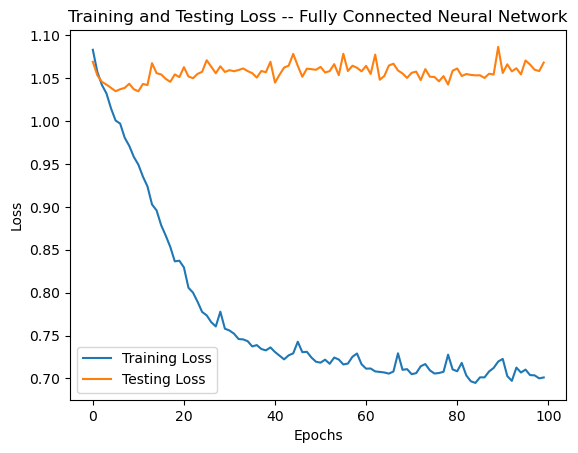

In [92]:
# Plot training and testing loss
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Testing Loss -- Fully Connected Neural Network')
plt.legend()
plt.show()

#### Calculate Test Accuracy

In [22]:
def get_accuracy(model, test_loader):
    # Test the model
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():  # Disable gradient calculation to save memory and speed up the process
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_accuracy = 100 * correct / total
    print(f"Test Weighted Accuracy: {test_accuracy:.2f}%")
    return test_accuracy

In [94]:
get_accuracy(model, test_loader)

Test Weighted Accuracy: 47.91%


47.911832946635734

#### Confusion Matrix

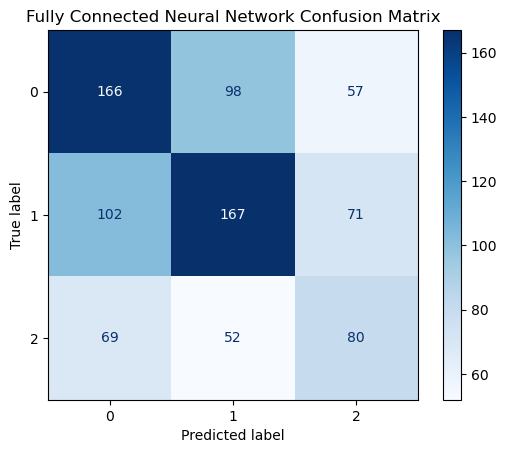

In [95]:
# plot confusion matrix
y_pred = []
with torch.no_grad():
    for X, y in test_loader:
        outputs = model(X.float())
        _, predicted = torch.max(outputs.data, 1)
        y_pred.extend(predicted.numpy())

cm = confusion_matrix(ytest, y_pred)
cm_display = ConfusionMatrixDisplay(cm).plot(
    values_format='d',
    cmap='Blues',
)
plt.title('Fully Connected Neural Network Confusion Matrix');

In [96]:
# Classification Report
print(classification_report(ytest, y_pred))

              precision    recall  f1-score   support

           0       0.49      0.52      0.50       321
           1       0.53      0.49      0.51       340
           2       0.38      0.40      0.39       201

    accuracy                           0.48       862
   macro avg       0.47      0.47      0.47       862
weighted avg       0.48      0.48      0.48       862



In [97]:
ytest_mat = pd.get_dummies(ytest)
ypred_mat = pd.get_dummies(ypred)
print(roc_auc_score(ytest_mat, ypred_mat, multi_class='ovo'))

0.5


___

### Bidirectional LSTM

In [15]:
# Define the bidirectional LSTM model
class BiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, num_layers, num_classes):
        super(BiLSTM, self).__init__()
        self.hidden_size1 = hidden_size1
        self.hidden_size2 = hidden_size2
        self.input_size = input_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size1, num_layers, batch_first=True, bidirectional=True)
        
        self.fc1 = nn.Linear(hidden_size1 * 2, hidden_size2)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size2, num_classes)

    def forward(self, x):
        # x shape: (batch_size, seq_length, input_size)
        x = x.view(-1, 1, self.input_size)
        
        # Initialize hidden and cell states
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size1).to(x.device)
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size1).to(x.device)

        # Pass input through the LSTM layer
        out, _ = self.lstm(x, (h0, c0))

        # Take the output of the last time step
        out = out[:, -1, :]
        
        # Pass through the fully connected layers
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        
        return out

In [16]:
# Prepare the data + loaders
Xtrain_blstm = torch.tensor(Xtrain.values, dtype=torch.float32)
ytrain_blstm = torch.tensor(ytrain.values, dtype=torch.long)
Xtest_blstm = torch.tensor(Xtest.values, dtype=torch.float32)
ytest_blstm = torch.tensor(ytest.values, dtype=torch.long)

batch_size = 32
train_ds = TensorDataset(Xtrain_blstm, ytrain_blstm)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_data = TensorDataset(Xtest_blstm, ytest_blstm)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [17]:
# Define model parameters
input_size = 384
sequence_length = 3
hidden_size1 = 256
hidden_size2 = 128
num_layers = 2
num_classes = 3

In [19]:
# Instantiate model
model = BiLSTM(input_size, hidden_size1, hidden_size2, num_layers, num_classes)

# Set the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [23]:
train_losses, test_losses = train_and_evaluate(model, train_loader, test_loader, criterion, optimizer, num_epochs=100, verbose=False)

Finished Training


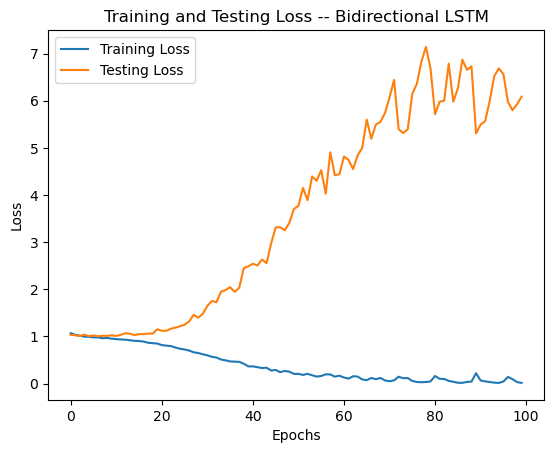

In [24]:
# Plot training and testing loss
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Testing Loss -- Bidirectional LSTM')
plt.legend();

In [25]:
get_accuracy(model, test_loader)

Test Weighted Accuracy: 47.91%


47.911832946635734

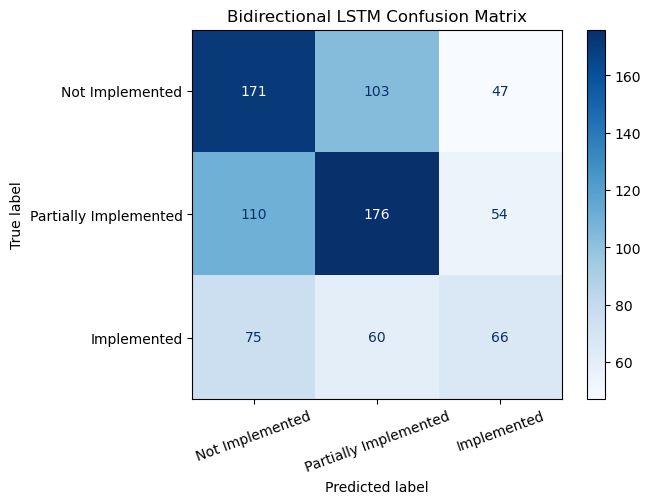

In [27]:
# confusion matrix
y_pred = []
with torch.no_grad():
    for X, y in test_loader:
        outputs = model(X.float())
        _, predicted = torch.max(outputs.data, 1)
        y_pred.extend(predicted.numpy())

cm = confusion_matrix(ytest, y_pred)
cm_display = ConfusionMatrixDisplay(
    cm,
    display_labels=['Not Implemented', 'Partially Implemented', 'Implemented']
    ).plot(
        values_format='d',
        cmap='Blues',
        xticks_rotation=20
    )
plt.title('Bidirectional LSTM Confusion Matrix');

In [28]:
print(classification_report(ytest, y_pred))

              precision    recall  f1-score   support

           0       0.48      0.53      0.51       321
           1       0.52      0.52      0.52       340
           2       0.40      0.33      0.36       201

    accuracy                           0.48       862
   macro avg       0.46      0.46      0.46       862
weighted avg       0.48      0.48      0.48       862



In [29]:
ytest_mat = pd.get_dummies(ytest)
ypred_mat = pd.get_dummies(ypred)
print(roc_auc_score(ytest_mat, ypred_mat, multi_class='ovo'))

0.5


___

## Conclusion

Unfortunately, it looks like none of our models can currently perform the classification task with sufficient consistency. 

> Here are the results:

| Model | Train Acc | Test Acc | F1 Score | ROC AUC |
| --- | --- | --- | --- | --- |
| Baseline | N/A | 0.37 | 0.20 | 0.50 |
| Logistic Regression | 0.46 | 0.44 | 0.46 | 0.58 |
| KNN Classifier | 0.44 | 0.43 | 0.45 | 0.58 |
| Gradient Boosting Classifier | 1 | 0.49 | 0.49 | 0.58 |
| Fully Connected Neural Network | 0.48 | 0.48 | 0.48 | 0.50 | 
| Bidirectional LSTM | 0.44 | 0.44 | 0.48 | 0.50 |

 In summary, the Gradient Boosting Classifier has the best Test Accuracy, F1 Score, and ROC AUC among all models. However, its overfitting issue should be addressed to improve generalization. The Logistic Regression, KNN Classifier, and Bidirectional LSTM models show similar performance levels but are better than the baseline model. The Fully Connected Neural Network has a slightly higher Test Accuracy than the aforementioned models but a worse ROC AUC.

 While these aren't the best scores, per se, we are still in the early stages of this project, and we have a lot of room to grow. As we collect more data and improve the pipeline to prevent data loss, we'll continue experimenting with these models. 

  I'm quite hesitant in asserting that the models are learning learning anything about the relationship between the word embeddings and the status of implementation yet. It could just be that they are randomly guessing a bit better than the baseline model. 
 
  In other words, the baseline dummy regressor doesn't even have the ability to "guess" other classes, but the models do! It might be by virtue of access to guessing alternatives that the models outperform the baseline. 
  
 - To test this in the future, we can create a few alternative baseline models to validate our test results against. 
 
 
>Though it's not quite clear at this point, if the models **are** learning something, support for  this claim is found in the models' marked improvement (2x) in F1 Score from the dummy classifier (baseline). 

##### My suspicion is that if this were converted to a binary classification problem with the category being fully implemented/not fully implemented, then the models would see a significant increase in performance.

___

### Long Form Model Results:

#### Baseline Model:
The Dummy Classifier with the "most_frequent" strategy is used as a baseline, and it's important to ensure that other models perform better than this. It has a Test Accuracy of 0.37, F1 Score of 0.20, and ROC AUC of 0.50, which are the lowest values among all models.

#### Logistic Regression: 
This model has a Train Accuracy of 0.46, Test Accuracy of 0.44, F1 Score of 0.46, and ROC AUC of 0.58. The model performs better than the baseline, but it's not the best-performing model in the list.

#### KNN Classifier: 
With Train Accuracy of 0.44, Test Accuracy of 0.43, F1 Score of 0.45, and ROC AUC of 0.58, the KNN Classifier is slightly worse than Logistic Regression in terms of accuracy and F1 score but equals it in ROC AUC.

#### Gradient Boosting Classifier:
This model seems to be overfitting, as it has a Train Accuracy of 1 but only a Test Accuracy of 0.49. Nevertheless, it has the highest Test Accuracy among all models. Its F1 Score and ROC AUC are 0.49 and 0.58, respectively, which are also the highest values among the models.

#### Fully Connected Neural Network: 
With Train Accuracy of 0.48, Test Accuracy of 0.48, F1 Score of 0.48, and ROC AUC of 0.50, this model performs better than the baseline but worse than the Gradient Boosting Classifier.

#### Bidirectional LSTM:
This model has a Train Accuracy of 0.44, Test Accuracy of 0.44, F1 Score of 0.48, and ROC AUC of 0.50. It has the same Test Accuracy as Logistic Regression but a better F1 Score and worse ROC AUC.
 
___